In [45]:
import statsmodels.api as sm
from math import factorial

import pathlib as pl
from configparser import ConfigParser
import itertools as itt

from tqdm import tqdm
import joblib as jl
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import Image

from src.utils.tools import get_quantile_means
from src.data.load import get_CPN_ids
from src.root_path import config_path
from src.visualization.palette import ColorList

config = ConfigParser()
config.read_file(open(config_path / 'settings.ini'))

In [14]:
summary_DF_file = pl.Path(config['paths']['analysis_cache']) / f'220310_ctx_mod_metric_DF_tstat_cluster_20hz'
summary_DF_file = pl.Path(config['paths']['analysis_cache']) / f'220310_ctx_mod_metric_DF_tstat_cluster_mass_chunked'

metrics = ['mass_center', 'last_bin', 'integral', 'integral_A', 'integral_B', 'integral_C', 'integral_D']
DF = jl.load(summary_DF_file).query(f"source == 'real' and metric in {metrics} and "
                                    f"cluster_threshold == 0.05 and mult_comp_corr == 'bf_cp' and "
                                    f"analysis == 'SC'")
DF.drop(columns=['source', 'cluster_threshold', 'mult_comp_corr', 'analysis'], inplace=True)

fr_DF_file = pl.Path(config['paths']['analysis_cache']) / f'220427_probe_firerates'
DF_fr = jl.load(fr_DF_file)

In [3]:
# Calculate delta firing rate
DF_dfr = DF_fr.query("part == 'context'"
                  ).pivot_table(index=['id', 'site', 'chunk', 'probe'], columns=['context'],
                                values='value', aggfunc='first')

n_comb = int(factorial(DF_dfr.shape[1]) /
                     (2 * factorial(DF_dfr.shape[1]-2)))
ctx_pair_R = np.full((DF_dfr.shape[0], n_comb), np.nan)
new_cols = list()
for pr_idx,(c0, c1) in enumerate(itt.combinations(DF_dfr.columns, r=2)):
    new_cols.append(f'{c0:02}_{c1:02}')
    ctx_pair_R[:, pr_idx] = np.abs(DF_dfr.values[:,c0] - DF_dfr.values[:,c1])

DF_dfr = pd.DataFrame(index=DF_dfr.index, columns=new_cols, data=ctx_pair_R
                      ).melt(var_name='context_pair', value_name='delta_fr', ignore_index=False).dropna().reset_index()
print(DF_dfr.head())
print(DF_dfr.shape)

             id     site chunk  probe context_pair  delta_fr
0  AMT020a-02-1  AMT020a     A      1        00_01  0.469999
1  AMT020a-02-1  AMT020a     A      2        00_01  0.387749
2  AMT020a-02-1  AMT020a     A      3        00_01  0.469999
3  AMT020a-02-1  AMT020a     A      4        00_01  0.610999
4  AMT020a-02-1  AMT020a     B      1        00_01  0.822499
(1977160, 6)


### regression
how are different delta fr from the context period affect the T value on different parts of the probe period

first for a given neuron

In [ ]:
# simple neuron regression
right = DF_dfr.pivot_table(index=['id', 'site', 'probe', 'context_pair'], columns='chunk', values='delta_fr'
                           ).reset_index()
reg_df = list()
for regressand in ['integral_A', 'integral_B', 'integral_C', 'integral_D']:
    toregress = pd.merge(left=DF.query(f"metric == '{regressand}' and value > 0"),
                          right=right, on=['id', 'site', 'probe', 'context_pair'])

    for neuron in toregress.id.unique():
        neu_df = toregress.query(f"id == '{neuron}'")

        # defines model and fits
        X = neu_df.loc[:,['A', 'B', 'C', 'D']].astype(float)
        X = sm.add_constant(X)
        Y = neu_df['value'].astype(float)
        model = sm.OLS(Y, X, hasconst=True)
        res = model.fit()

        # parses out regression weights i.e. slopes
        try:
            weights = res.params.drop(index='const') # sometime there is no parameters when the regression fails
        except:
            continue
        weights.name='weigths'
        CI = res.conf_int().drop(index='const').rename(columns={0:'lower_ci',1:'upper_ci'})

        # compiles in a df with extra info about results source
        d = pd.concat([weights, CI], axis=1)
        d['id'] = neuron
        d['regresor'] = 'self'
        d['regressand'] = regressand

        reg_df.append(d)

reg_df = pd.concat(reg_df)

  chunk     weigths   lower_ci    upper_ci            id regresor  regressand
0     A  -87.158131        NaN         NaN  ARM033a-51-3     self  integral_A
1     B  -87.060897        NaN         NaN  ARM033a-51-3     self  integral_A
2     C   56.355451        NaN         NaN  ARM033a-51-3     self  integral_A
3     D   94.863377        NaN         NaN  ARM033a-51-3     self  integral_A
4     A  259.058681  66.168394  451.948968  ARM033a-06-1     self  integral_A


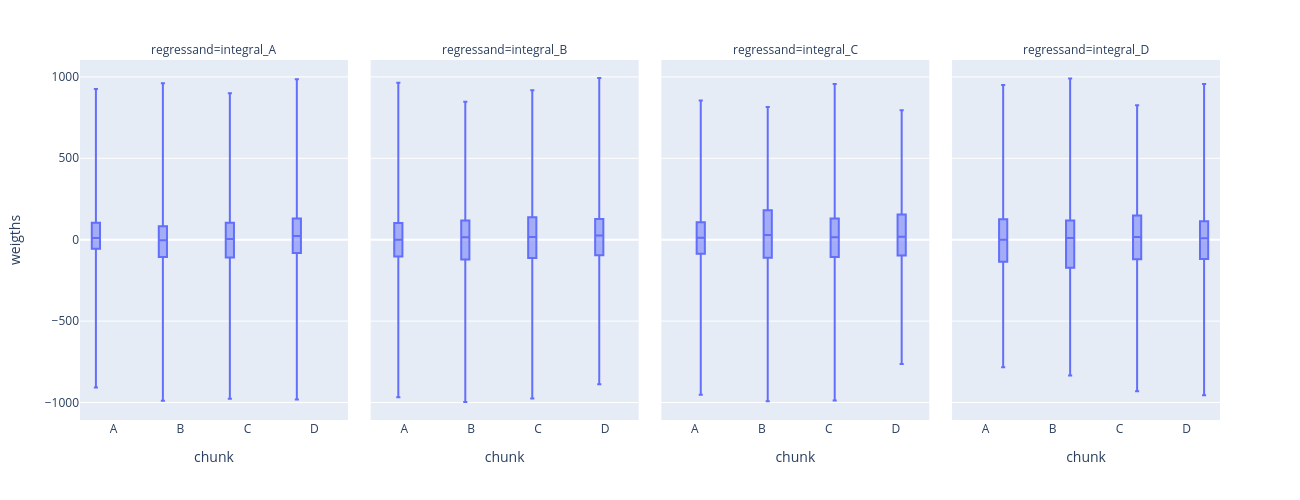

In [202]:
toplot = reg_df.reset_index().rename(columns={'index':'chunk'}).query('weigths < 1000 and weigths >-1000')
print(toplot.head())

fig = px.box(toplot.reset_index(), x='chunk', y='weigths', points=False, facet_col='regressand')
# fig.show()
img_bytes = fig.to_image(format="png", width=1300, height=500)
Image(img_bytes)

### recreate old results

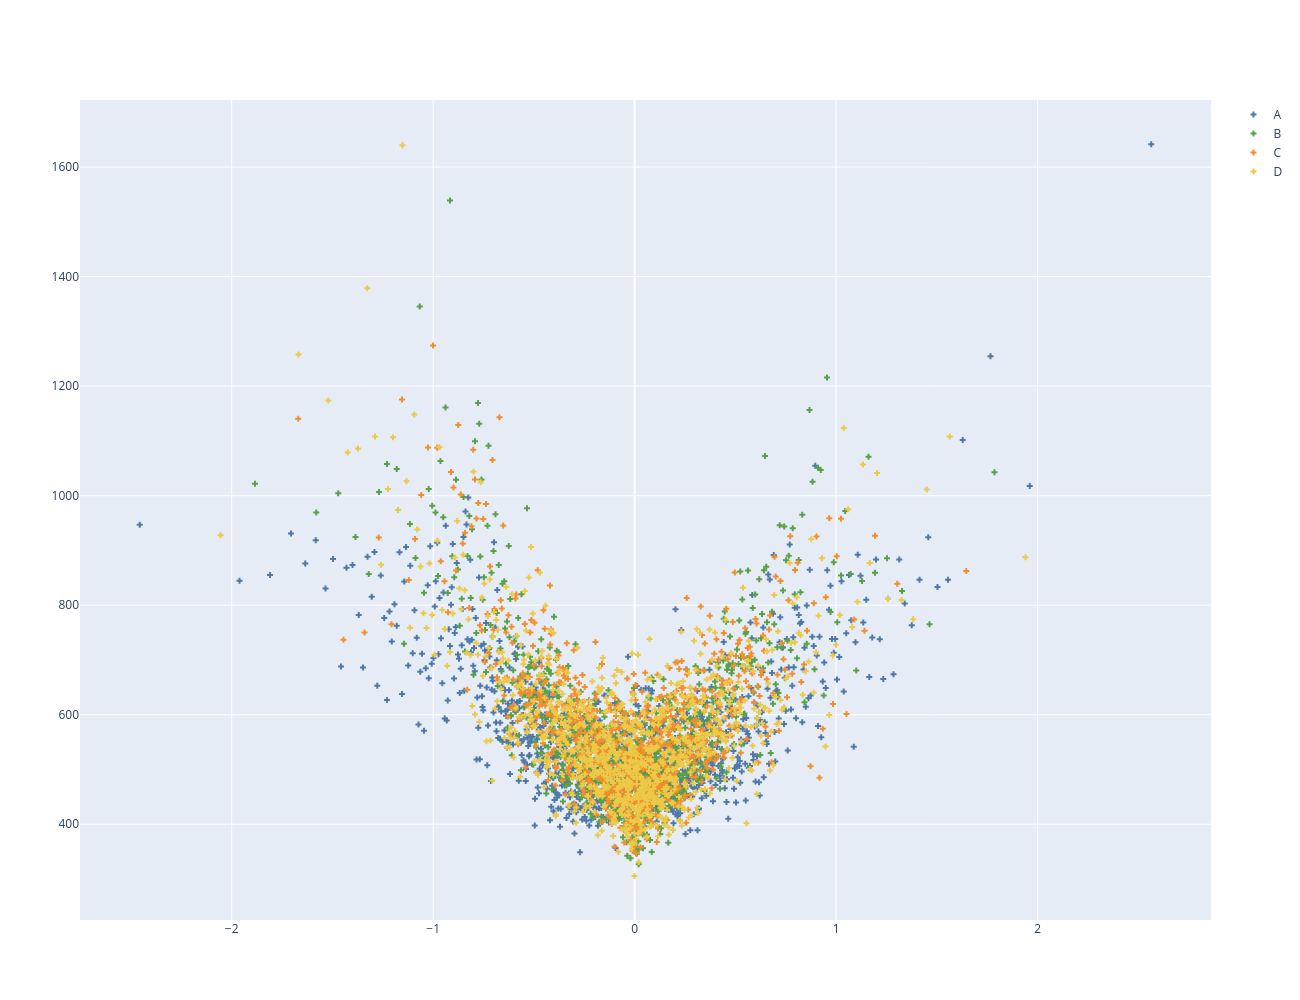

In [200]:
# Y is the center of mass, or better the last bin. X is the delta firing rate at different times
right = DF_dfr.pivot_table(index=['id', 'site', 'probe', 'context_pair'], columns='chunk', values='delta_fr'
                           ).reset_index()
# right = DF_dfr
left = DF.query("metric == 'integral' and value >0")
toregress = pd.merge(left, right, on=['id', 'context_pair', 'probe'])

# fig = make_subplots(1, 4)
fig = go.Figure()
for cc, chunk in enumerate(['A','B','C','D']):
    # scatter
    # rndsmp = np.random.random_sample(size=x.shape) < 0.2 # subsamples 20% of the data
    color = ColorList[cc%len(ColorList)]

    # fig.add_trace(go.Scattergl(x=toregress['A'], y=toregress['value'], mode='markers',
    #                            opacity=0.3,
    #                            marker=dict(opacity=0.5,
    #                                        size=3,
    #                                        color=color,
    #                                        line_color='black'),
    #                            showlegend=False,
    #                            hoverinfo='skip'))

    # trendline
    xm, ym = get_quantile_means(x=toregress[chunk], y=toregress['value'], n_quantiles=1000)
    fig.add_trace(go.Scatter(x=xm, y=ym, mode='markers',
                             marker=dict(opacity=1,
                                         color=color,
                                         symbol='cross',
                                         size=5),
                             line_width=2,
                             name=chunk,
                             showlegend=True))


img_bytes = fig.to_image(format="png", width=1300, height=1000)
Image(img_bytes)

# Regress delta fr to itself!

In [107]:
# Calculate delta firing rate
DF_dfr = DF_fr.query("context != 'mean'"
                  ).pivot_table(index=['part', 'id', 'site', 'chunk', 'probe'], columns=['context'],
                                values='value', aggfunc='first')

n_comb = int(factorial(DF_dfr.shape[1]) /
                     (2 * factorial(DF_dfr.shape[1]-2)))
ctx_pair_R = np.full((DF_dfr.shape[0], n_comb), np.nan)
new_cols = list()
for pr_idx,(c0, c1) in enumerate(itt.combinations(DF_dfr.columns, r=2)):
    new_cols.append(f'{c0:02}_{c1:02}')
    ctx_pair_R[:, pr_idx] = DF_dfr.values[:,c0] - DF_dfr.values[:,c1]

DF_dfr = pd.DataFrame(index=DF_dfr.index, columns=new_cols, data=ctx_pair_R
                      ).melt(var_name='context_pair', value_name='delta_fr', ignore_index=False).dropna().reset_index()
print(DF_dfr.head())

      part            id     site chunk  probe context_pair  delta_fr
0  context  AMT020a-02-1  AMT020a     A      1        00_01 -0.469999
1  context  AMT020a-02-1  AMT020a     A      2        00_01 -0.387749
2  context  AMT020a-02-1  AMT020a     A      3        00_01 -0.469999
3  context  AMT020a-02-1  AMT020a     A      4        00_01 -0.610999
4  context  AMT020a-02-1  AMT020a     B      1        00_01 -0.822499


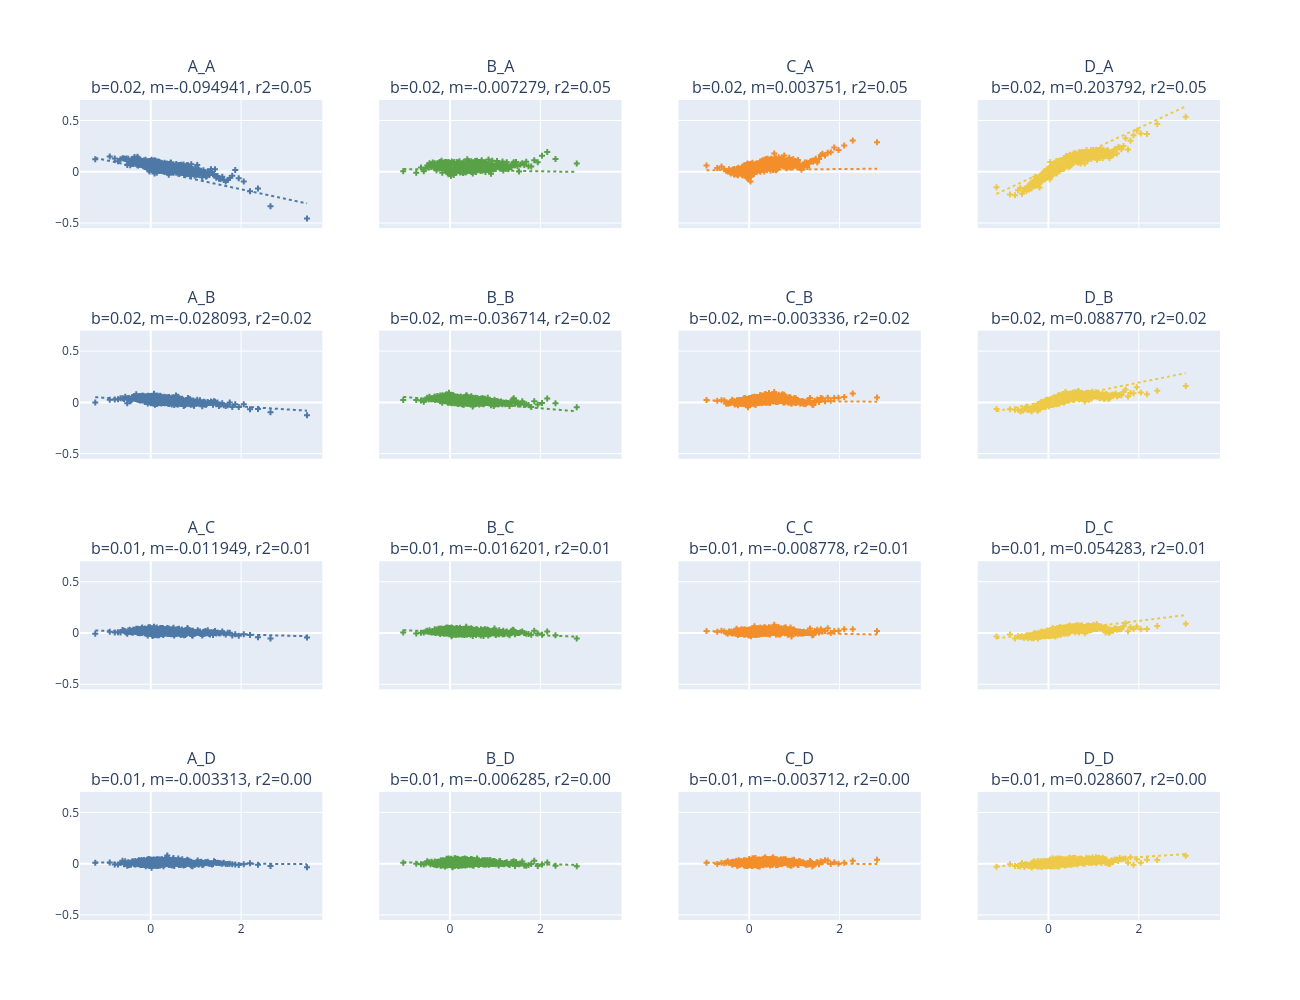

In [197]:
fig = make_subplots(4, 4, shared_xaxes='all', shared_yaxes='all',
                    subplot_titles=[f"{CC}_{PC}" for PC, CC in itt.product(['A','B','C','D'], repeat=2)])

left = DF_dfr.query("part == 'context'")
res_dict = dict()
subtitles = dict()
for pc, prb_chunk in enumerate(['A','B','C','D']):
    right = DF_dfr.query(f"part == 'probe' and chunk == '{prb_chunk}'")

    toregress = pd.merge(left, right, on=['id', 'probe', 'context_pair'], validate="m:1"
                         ).pivot_table(index=['id', 'context_pair', 'probe', 'delta_fr_y'],
                                       columns=['chunk_x'],
                                       values='delta_fr_x', aggfunc='first').reset_index().copy()

    # flips values to enforce positive x since its an arbitrary sing.
    # alax x are related, and they might have opposite signs, takes  the mean across them

    # flipper = (toregress['delta_fr_y'] >= 0) * 2 -1
    # flipper = (toregress.loc[:,'D'] >= 0) * 2 -1
    flipper = (toregress.loc[:,['A', 'B', 'C', 'D']].values.mean(axis=1) >= 0) * 2 -1
    toregress.loc[:,['delta_fr_y','A', 'B', 'C', 'D']] = toregress.loc[:,['delta_fr_y','A', 'B', 'C', 'D']
                                                         ].values * flipper[:,None]


    # run regression
    X = toregress.loc[:,['A', 'B', 'C', 'D']].astype(float)
    X = sm.add_constant(X)
    Y = toregress['delta_fr_y'].astype(float)
    model = sm.OLS(Y, X, hasconst=True)
    res = model.fit()
    res_dict[prb_chunk] = res


    for cc, ctx_chunk in enumerate(['A','B','C','D']):

        color = ColorList[cc%len(ColorList)]

        x = toregress[ctx_chunk].values
        y = toregress['delta_fr_y'].values

        # decimated scatterplot
        xm, ym = get_quantile_means(x=x, y=y, n_quantiles=1000)
        fig.add_trace(go.Scatter(x=xm, y=ym, mode='markers',
                                 marker=dict(opacity=1,
                                             color=color,
                                             symbol='cross',
                                             size=5),
                                 line_width=2,
                                 name=chunk,
                                 showlegend=False), row=pc+1, col=cc+1)

        xr = np.asarray([np.nanmin(xm), np.nanmax(xm)]).squeeze().astype(float)
        yr = res.params['const'] + xr * res.params[ctx_chunk]

        fig.add_trace(go.Scatter(x=xr, y=yr, mode='lines',
                                 line=dict(width=2,
                                           color=color,
                                           dash='dot'),
                                 showlegend=False), row=pc+1, col=cc+1)


        # saves subplot title
        name = f"{ctx_chunk}_{prb_chunk}<br>" \
               f"b={res.params['const']:.2f}, m={res.params[ctx_chunk]:2f}, r2={res.rsquared:.2f}"
        subtitles[f'{ctx_chunk}_{prb_chunk}'] = name

fig.update_layout(showlegend=False)
# names = {'Plot 1':'2016', 'Plot 2':'2017', 'Plot 3':'2018', 'Plot 4':'2019'}
fig.for_each_annotation(lambda a: a.update(text = subtitles[a.text]))

# fig.show()
img_bytes = fig.to_image(format="png", width=1300, height=1000)
Image(img_bytes)